In [1]:
# Import necessary libraries for the task
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from datetime import datetime

# Setting Plotly default theme
import plotly.io as pio
pio.templates.default = "plotly_white"



## Load and Preprocess the Dataset

In [2]:
# Load the dataset
df = pd.read_csv("chatgpt_reviews.csv")

# Handle missing values in the 'Review' column by replacing them with empty strings
df['Review'] = df['Review'].astype(str).fillna('')

# Convert 'Review Date' to datetime format
df['Review Date'] = pd.to_datetime(df['Review Date'])

# Display the first few rows of the dataset
df.head()


,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


Let’s have a look at whether the dataset has any null values or not:

In [3]:
df.isnull().sum()

Review Id      0
Review         0
Ratings        0
Review Date    0
dtype: int64

## Sentiment Analysis using Transformers

In [15]:
# Hugging Face
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch
import numpy as np

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # GPU: 0, CPU: -1

In [14]:
# Set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

# set the deterministic flag
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import torch

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # GPU: 0, CPU: -1

# Specify the model ID from Hugging Face
model_id = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load the model from Hugging Face
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=3  # The model is fine-tuned for 3 labels: positive, negative, neutral
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model & tokenizer into the pipeline for sentiment analysis
nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,  # Use GPU if available
    truncation=True,  # Truncate input if it exceeds the max length
    max_length=512  # Ensure the token length does not exceed 512
)

# Apply sentiment analysis to the 'Review' column with truncation
df['Sentiment'] = df['Review'].apply(lambda review: nlp(review[:512])[0]['label'])

# Display the dataset with sentiment labels
df.head()


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Review Id,Review,Ratings,Review Date,Sentiment
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,positive
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,positive
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,positive
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,positive
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,positive


## Sentiment Distribution Plot

In [31]:
import plotly.express as px

# Count the sentiment distribution
sentiment_distribution = df['Sentiment'].value_counts()

# Create a basic bar plot of sentiment distribution
fig = px.bar(x=sentiment_distribution.index, 
             y=sentiment_distribution.values,
             labels={'x': 'Sentiment', 'y': 'Count'},
             title='Sentiment Distribution of ChatGPT Reviews')

# Display the plot
fig.show()

### Analyzing Reviews Over Time

Track how sentiment changes over time by aggregating reviews by month or year.

In [32]:
# Convert 'Review Date' to datetime format if not already done
df['Review Date'] = pd.to_datetime(df['Review Date'])



In [33]:
# Group by month and sentiment, count the occurrences
sentiment_over_time = df.groupby([df['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)


In [37]:
# Convert the PeriodIndex to string for Plotly compatibility
sentiment_over_time.index = sentiment_over_time.index.astype(str)

* Converts the PeriodIndex to a string representation that Plotly can handle for plotting.

In [38]:


# Plot sentiment trends over time
fig = px.line(sentiment_over_time, 
              x=sentiment_over_time.index, 
              y=['negative', 'neutral', 'positive'],  # Ensure the column names match
              labels={'x': 'Month', 'y': 'Number of Reviews'},
              title='Sentiment Trends Over Time')

# Display the plot
fig.show()

## Extract and Visualize Common Phrases (N-grams):

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

# Filter positive reviews
positive_reviews = df[df['Sentiment'] == 'positive']['Review']

# Initialize CountVectorizer for bigrams (2-grams) or trigrams (3-grams)
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=20)

# Fit and transform the positive reviews to extract the n-grams
X_pos = vectorizer.fit_transform(positive_reviews)


In [40]:
# Get the n-grams and their frequencies
ngrams_pos = vectorizer.get_feature_names_out()
ngram_counts_pos = X_pos.sum(axis=0).tolist()[0]


In [41]:
# Create a DataFrame for visualization
positive_ngrams_df = pd.DataFrame({'Phrase': ngrams_pos, 'Frequency': ngram_counts_pos})

# Sort by frequency
positive_ngrams_df = positive_ngrams_df.sort_values(by='Frequency', ascending=False)


In [42]:
# Plot the top n-grams in positive reviews
fig = px.bar(positive_ngrams_df, 
             x='Frequency', 
             y='Phrase', 
             orientation='h', 
             title='Top Common Phrases in Positive Reviews')
fig.show()

## Extract and Visualize N-grams for Negative Reviews

In [43]:
# Filter negative reviews
negative_reviews = df[df['Sentiment'] == 'negative']['Review']

# Fit and transform the negative reviews to extract the n-grams
X_neg = vectorizer.fit_transform(negative_reviews)

# Get the n-grams and their frequencies
ngrams_neg = vectorizer.get_feature_names_out()
ngram_counts_neg = X_neg.sum(axis=0).tolist()[0]



In [44]:
# Create a DataFrame for visualization
negative_ngrams_df = pd.DataFrame({'Phrase': ngrams_neg, 'Frequency': ngram_counts_neg})

# Sort by frequency
negative_ngrams_df = negative_ngrams_df.sort_values(by='Frequency', ascending=False)


In [45]:
negative_ngrams_df.head()

,Phrase,Frequency
4,chat gpt,486
5,doesn work,399
13,try later,324
6,don know,234
9,good app,219


In [46]:
# Plot the top n-grams in negative reviews
fig = px.bar(negative_ngrams_df, 
             x='Frequency', 
             y='Phrase', 
             orientation='h', 
             title='Top Common Phrases in Negative Reviews')
fig.show()


## Sentiment vs. Ratings Correlation:
Analyze how sentiment relates to ratings. Do higher-rated reviews correlate with more positive sentiments? Are there any discrepancies where people rate the product highly but express neutral or negative sentiments?

<Axes: title={'center': 'Sentiment Distribution by Ratings'}, xlabel='Ratings'>

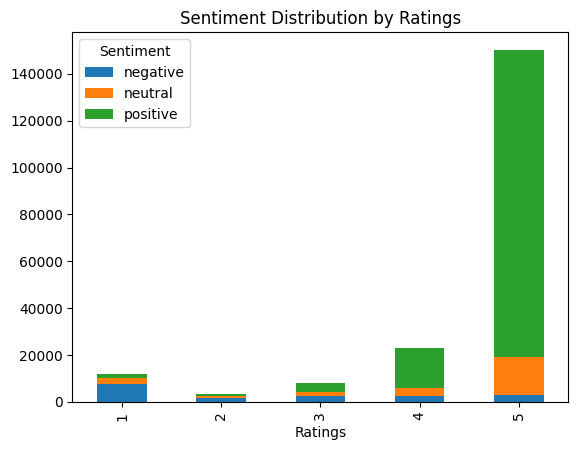

In [47]:
# Group the data by Ratings and Sentiment to see the distribution
sentiment_ratings = df.groupby(['Ratings', 'Sentiment']).size().unstack(fill_value=0)

# Visualize the correlation between Ratings and Sentiment
sentiment_ratings.plot(kind='bar', stacked=True, title='Sentiment Distribution by Ratings')


## User Review Length Analysis:
Analyze the length of the reviews (number of words or characters) and see how that relates to the sentiment. Do longer reviews tend to be more negative or more positive?

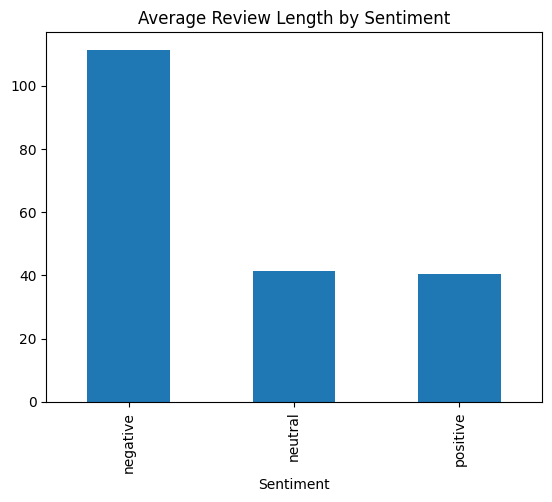

In [49]:
# Add a column for review length
df['Review Length'] = df['Review'].apply(len)

# Compare average review length by sentiment
review_length_by_sentiment = df.groupby('Sentiment')['Review Length'].mean()

# Plot review length by sentiment
review_length_by_sentiment.plot(kind='bar', title='Average Review Length by Sentiment');


## Net Promoter Score (NPS) Calculation:
The Net Promoter Score (NPS) is a customer loyalty metric. You can categorize reviews into Promoters, Passives, and Detractors based on their ratings, and calculate the NPS to see how likely users are to recommend the product.

In [50]:
# Define the categories based on the ratings
df['NPS Category'] = df['Ratings'].apply(lambda x: 'Promoter' if x == 5 else ('Passive' if x == 4 else 'Detractor'))

# Calculate the percentage of each category
nps_counts = df['NPS Category'].value_counts(normalize=True) * 100

# Calculate NPS
nps_score = nps_counts.get('Promoter', 0) - nps_counts.get('Detractor', 0)

print(f"Net Promoter Score (NPS): {nps_score}")


Net Promoter Score (NPS): 64.35313912172705


### Net Promoter Score (NPS) Analysis

**NPS Value**: 64.35

This is a **solid score**, indicating that a significant proportion of users are **Promoters** (those who rate your product highly and are likely to recommend it to others).

### Interpreting the NPS:

- **NPS > 50**:  
  This is generally considered **excellent**, meaning a large number of users are satisfied with the product.
  
- **NPS between 0 and 50**:  
  This is considered **good**, but it indicates there is room for improvement.
  
- **NPS < 0**:  
  This suggests a high number of dissatisfied users, which requires immediate attention.

### A NPS of 64.35:
- This score means that **most users are happy** with the product and willing to recommend it.
- However, there may still be some **detractors** (users who rated the product low), and addressing their concerns could help to further improve the score.



In [51]:
# Filter reviews by NPS categories
promoter_reviews = df[df['NPS Category'] == 'Promoter']['Review']
detractor_reviews = df[df['NPS Category'] == 'Detractor']['Review']
passive_reviews = df[df['NPS Category'] == 'Passive']['Review']


Analyze Common Themes (N-grams) for Each Category
We can reuse the CountVectorizer technique to extract common phrases (n-grams) from each group.

### a. Promoters - Analyze common phrases

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer for bigrams and trigrams
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=20)

# Fit and transform promoter reviews
X_promoter = vectorizer.fit_transform(promoter_reviews)

# Get the n-grams and their frequencies
ngrams_promoter = vectorizer.get_feature_names_out()
ngram_counts_promoter = X_promoter.sum(axis=0).tolist()[0]

# Create a DataFrame for visualization
promoter_ngrams_df = pd.DataFrame({'Phrase': ngrams_promoter, 'Frequency': ngram_counts_promoter})

# Sort by frequency
promoter_ngrams_df = promoter_ngrams_df.sort_values(by='Frequency', ascending=False)

# Plot the top n-grams for promoters
fig = px.bar(promoter_ngrams_df, 
             x='Frequency', 
             y='Phrase', 
             orientation='h', 
             title='Top Common Phrases in Promoter Reviews')
fig.show()


### b. Detractors - Analyze common phrases

In [53]:
# Fit and transform detractor reviews
X_detractor = vectorizer.fit_transform(detractor_reviews)

# Get the n-grams and their frequencies
ngrams_detractor = vectorizer.get_feature_names_out()
ngram_counts_detractor = X_detractor.sum(axis=0).tolist()[0]

# Create a DataFrame for visualization
detractor_ngrams_df = pd.DataFrame({'Phrase': ngrams_detractor, 'Frequency': ngram_counts_detractor})

# Sort by frequency
detractor_ngrams_df = detractor_ngrams_df.sort_values(by='Frequency', ascending=False)

# Plot the top n-grams for detractors
fig = px.bar(detractor_ngrams_df, 
             x='Frequency', 
             y='Phrase', 
             orientation='h', 
             title='Top Common Phrases in Detractor Reviews')
fig.show()


### c. Passives - Analyze common phrases

In [ ]:
# Fit and transform passive reviews
X_passive = vectorizer.fit_transform(passive_reviews)

# Get the n-grams and their frequencies
ngrams_passive = vectorizer.get_feature_names_out()
ngram_counts_passive = X_passive.sum(axis=0).tolist()[0]

# Create a DataFrame for visualization
passive_ngrams_df = pd.DataFrame({'Phrase': ngrams_passive, 'Frequency': ngram_counts_passive})

# Sort by frequency
passive_ngrams_df = passive_ngrams_df.sort_values(by='Frequency', ascending=False)

# Plot the top n-grams for passives
fig = px.bar(passive_ngrams_df, 
             x='Frequency', 
             y='Phrase', 
             orientation='h', 
             title='Top Common Phrases in Passive Reviews')
fig.show()
